# AI Bootcamp - Introduction to machine learning
## Problemy regresji i uczenie nienadzorowane

In [1]:
import math
import time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.datasets import fetch_openml, load_boston, make_blobs
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

### Dane

**CRIM:** Per capita crime rate by town  
**ZN:** Proportion of residential land zoned for lots over 25,000 sq. ft  
**INDUS:** Proportion of non-retail business acres per town  
**CHAS:** Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)  
**NOX:** Nitric oxide concentration (parts per 10 million)  
**RM:** Average number of rooms per dwelling  
**AGE:** Proportion of owner-occupied units built prior to 1940  
**DIS:** Weighted distances to five Boston employment centers  
**RAD:** Index of accessibility to radial highways  
**TAX:** Full-value property tax rate per \\$10,000  
**PTRATIO:** Pupil-teacher ratio by town  
**B:** 1000(Bk — 0.63)², where Bk is the proportion of [people of African American descent] by town  
**LSTAT:** Percentage of lower status of the population  
**MEDV:** Median value of owner-occupied homes in \\$1000s  

In [3]:
# Załadujmy zbiór danych dotyczących cen mieszkań w Bostonie
boston_dataset = load_boston()

In [4]:
# Wrzucamy zbiór w pandasowy DataFrame, żeby móc na nim wygodnie wykonywać różne operacje
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)

# Zwraca pierwszych pięć rekordów DataFrama
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [5]:
# Dodajemy brakująca kolumnę, której wartość później będziemy próbowali przewidzieć
boston["MEDV"] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
# pandas pozwala nam na przykład policzyć podstawowe statystyki dla poszczególnych kolumn (cech) w zbiorze danych
boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


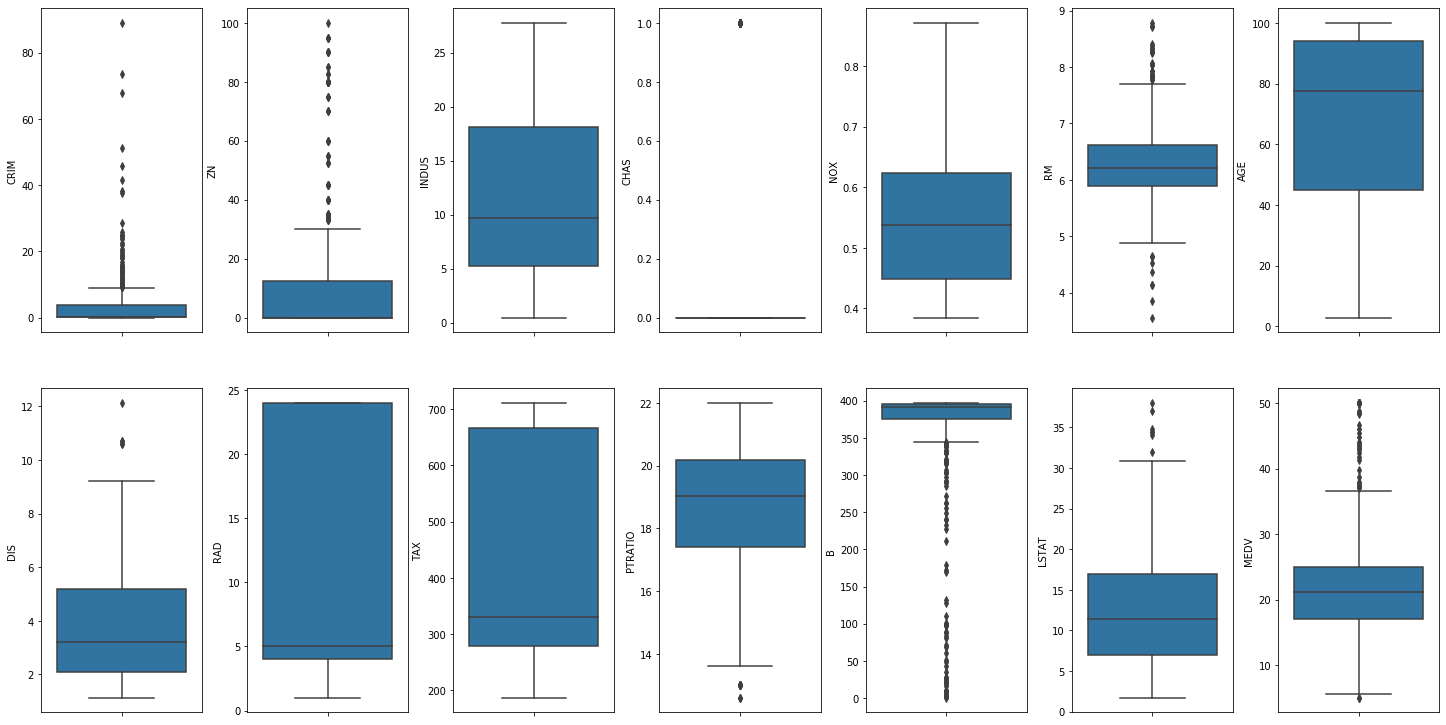

In [7]:
# Z pandasem możemy też w łatwy sposób rysować różne wykresy na podstawie informacji zawartych w zbiorze danych
fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
index = 0
axs = axs.flatten()
for col in boston.columns:
    sns.boxplot(y=col, data=boston[[col]], ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

## Regresja

### Regresja liniowa (Linear regression)
https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931  
https://www.geeksforgeeks.org/gradient-descent-in-linear-regression/

In [8]:
# Dzielimy zbiór danych na zbiory uczący i testowy
train_boston, test_boston = train_test_split(boston, test_size=0.2, random_state=4)
print(train_boston.shape)
print(test_boston.shape)

(404, 14)
(102, 14)


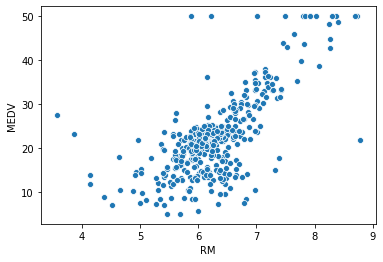

In [9]:
# Zobaczmy na wykresie jak rozkładają się mediany cen mieszkań w zależności od konkretnych cech
x_label = "RM"  # wybierz cechę na podstawie, podstawie której zostanie narysowany wykres

plt.figure()
ax = sns.scatterplot(x=x_label, y="MEDV", data=train_boston[[x_label,"MEDV"]])

In [10]:
# Lista nazw cech, których będziemy używać
features = ["RM"]

# Przygotowanie zbiorów uczącego i testowego przy wykorzystaniu wyłącznie cechy RM
x_train, x_test = train_boston[features], test_boston[features]
y_train, y_test = train_boston["MEDV"], test_boston["MEDV"]

# Model spodziewa się listy cech dla każdego rekordu, więc musimy zmienić nieco strukturę zbioru przykładów
x_train = x_train.to_numpy().reshape(-1, 1)
x_test = x_test.to_numpy().reshape(-1, 1)

# Zobaczmy jaki ostatecznie kształt mają tablice z danymi oraz etykietami
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(404, 1)
(102, 1)
(404,)
(102,)


In [11]:
# Tworzymy model regresji liniowej i uczymy go na zbiorze uczącym
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
# Sprawdźmy jak model sobie radzi
# Liczymy błąd średniokwadratowy na zbiorze uczącym
y_train_predict = lin_model.predict(x_train)
mse_train = mean_squared_error(y_train, y_train_predict)

print("Model performance on training data")
print(f"MSE: {mse_train}")
print()

# Liczymy błąd średniokwadratowy na zbiorze testowym
y_test_predict = lin_model.predict(x_test)
mse_test = mean_squared_error(y_test, y_test_predict)

print("Model performance on test data")
print(f"MSE: {mse_test}")
print()

Model performance on training data
MSE: 41.61505007139243

Model performance on test data
MSE: 51.60929995125552



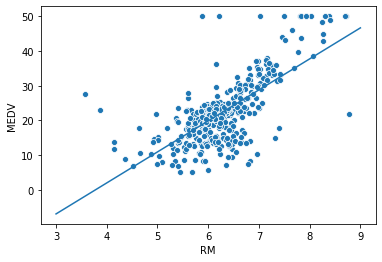

In [13]:
# Narysujmy wykres MEDV w zależności od RM oraz predykcję naszego modelu liniowego
plt.figure()
ax = sns.scatterplot(x=x_label, y="MEDV", data=train_boston[[x_label,"MEDV"]])
tmp_x = np.array([[3,],[9,]])
tmp_y = lin_model.predict(tmp_x)
plt.plot(tmp_x, tmp_y)

In [14]:
# Lista nazw cech, których będziemy używać
features = ["RM", "LSTAT"]

# Przygotowanie zbiorów uczącego i testowego przy wykorzystaniu cech RM i LSTAT
x_train, x_test = train_boston[features], test_boston[features]
y_train, y_test = train_boston["MEDV"], test_boston["MEDV"]

# Zobaczmy jaki ostatecznie kształt mają tablice z danymi oraz etykietami
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(404, 2)
(102, 2)
(404,)
(102,)


In [15]:
# Tworzymy nowy model regresji liniowej i uczymy go na nowym zbiorze uczącym
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
# Jeszcze raz liczymy błędy średniokwadratowe
y_train_predict = lin_model.predict(x_train)
mse_train = mean_squared_error(y_train, y_train_predict)

print("Model performance on training data")
print(f"MSE: {mse_train}")
print()

y_test_predict = lin_model.predict(x_test)
mse_test = mean_squared_error(y_test, y_test_predict)

print("Model performance on test data")
print(f"MSE: {mse_test}")
print()
print("Model still underfitted")

Model performance on training data
MSE: 29.9133862914607

Model performance on test data
MSE: 33.2510151037294

Model still underfitted


### Las losowy (RandomForest)

In [17]:
# Tym razem użyjemy innego modelu
rnd_for_model = RandomForestRegressor()
rnd_for_model.fit(x_train, y_train)

/home/leet/Documents/Golem/bootcamp/.venv/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [18]:
# Znowu liczymy błąd
y_train_predict = rnd_for_model.predict(x_train)
mse_train = mean_squared_error(y_train, y_train_predict)

print("Model performance on training data")
print(f"MSE: {mse_train}")
print()

y_test_predict = rnd_for_model.predict(x_test)
mse_test = mean_squared_error(y_test, y_test_predict)

print("Model performance on test data")
print(f"MSE: {mse_test}")
print()
print("Model overfitted")

Model performance on training data
MSE: 4.829364851485149

Model performance on test data
MSE: 26.5145088235294

Model overfitted


Obciążenie vs Wariancja (Bias vs Variance) => https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

# Uczenie nienadzorowane (Unsupervised learning)

## Grupowanie (Clustering) (inaczej analiza skupień)

### grupowanie k-średnich (k-means clustering)
https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/

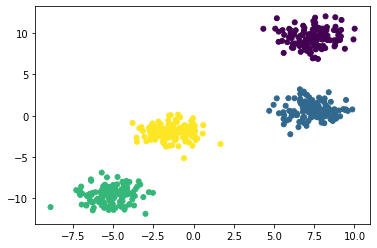

In [19]:
# Tworzymy 4 dobrze odseparowane od siebie chmury punktów, akurat random_state=8 daje dobry wynik
X, hidden = make_blobs(n_samples=500, centers=4, n_features=2, random_state=8)

# Rysujemy chmury pokolorowane na różne kolory
plt.scatter(X[:,0], X[:,1], c=hidden, marker="o", s=25)

In [20]:
# Sprawdźmy dla ilu grup przy grupowaniu algorytmem KMeans otrzymamy najwyższy wynik. Zakres [-1, 1]
k=6

# Dzielimy zbiór na k grup algorytmem KMeans
clusterer = KMeans(n_clusters=k, random_state=3)
cluster_labels = clusterer.fit_predict(X)

# Wyliczamy i wypisujemy średni współczynnik sylwetki, im bliżej liczby 1 tym lepiej punkty są pogrupowane
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"{k} clusters score: {silhouette_avg}")

6 clusters score: 0.5468868777579295


In [21]:
# Sprawdźmy więcej możliwości
for i in range(2,10):
    clusterer = KMeans(n_clusters=i, random_state=3)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(f"{i} clusters score: {silhouette_avg}")

2 clusters score: 0.6450622653451974
3 clusters score: 0.6732127122632685
4 clusters score: 0.7844089152826992
5 clusters score: 0.6642425085582565
6 clusters score: 0.5468868777579295
7 clusters score: 0.434490460465751
8 clusters score: 0.33543751074058586
9 clusters score: 0.3471445638519002


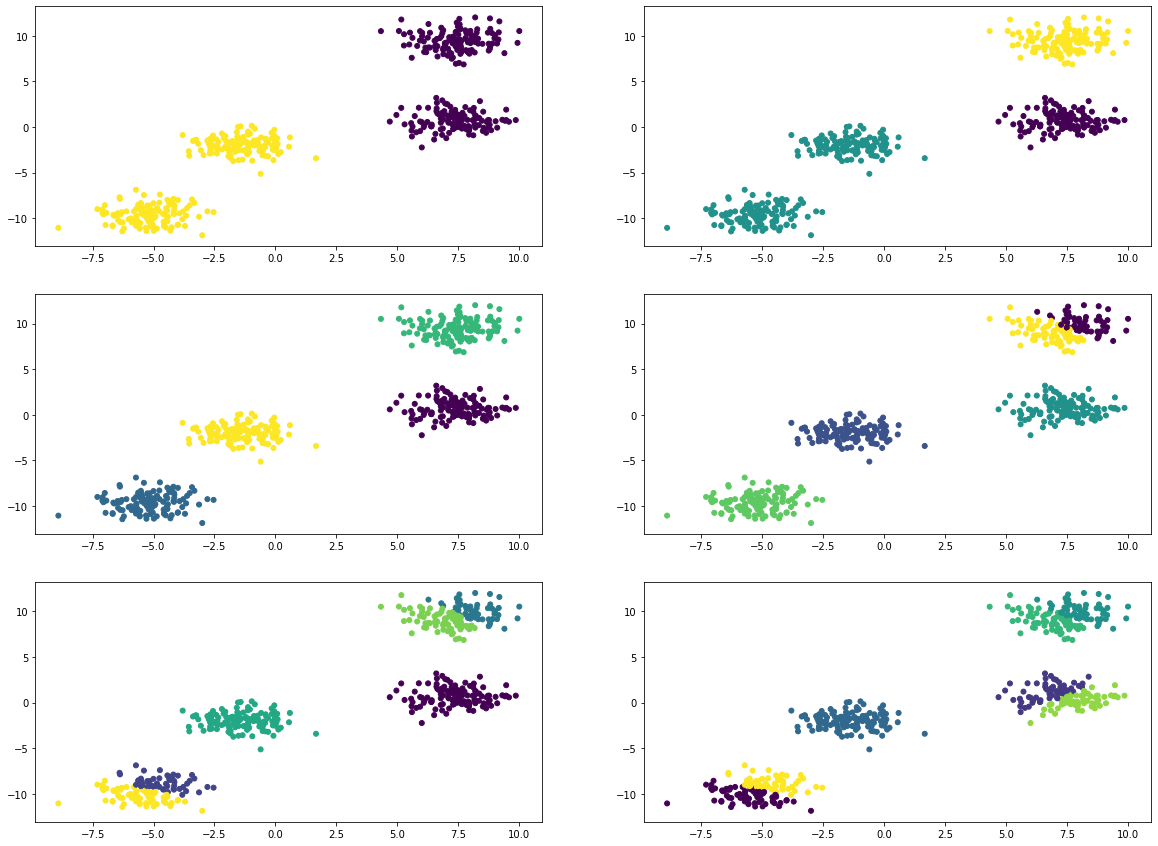

In [22]:
# Zobaczmy jak poszczególne wyniki KMeans wyglądają na wykresie

# Wybierz ile wykresów ma być wyrysowanych
nplots = 6  # k = 2,3,...,nplots+1
num_rows = math.ceil(nplots/2)

fig, axs = plt.subplots(ncols=2, nrows=num_rows, figsize=(20, num_rows*5))
for i in range(2,2+nplots):
    clusterer = KMeans(n_clusters=i, random_state=3)
    cluster_labels = clusterer.fit_predict(X)
    axs[int((i-2)/2),(i-2)%2].scatter(X[:,0], X[:,1], c=cluster_labels, marker="o", s=25)

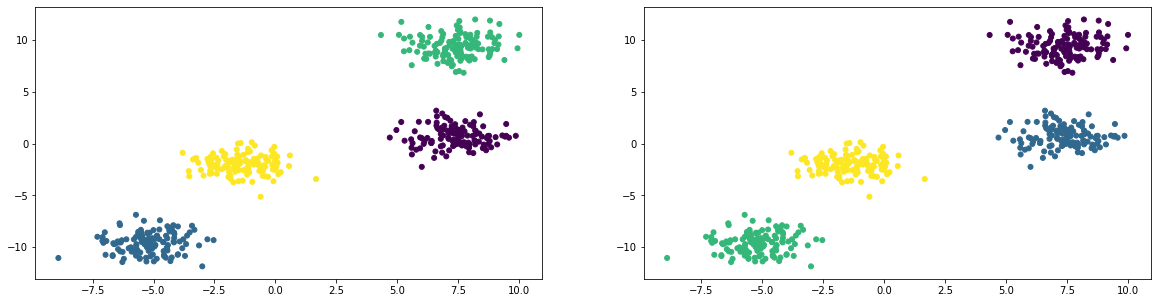

In [23]:
# Skoro już wiemy, że k=4 to najlepszy wybór to porównajmy wynik grupowania, do faktycznych ukrytych grup
clusterer = KMeans(n_clusters=4, random_state=3)
cluster_labels = clusterer.fit_predict(X)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
# Rysujemy wynik grupowania (lewy wykres) oraz faktyczne ukryte grupy (prawy wykres)
axs[0].scatter(X[:,0], X[:,1], c=cluster_labels, marker="o", s=25)
axs[1].scatter(X[:,0], X[:,1], c=hidden, marker="o", s=25)

## Zmniejszanie wymiarowości (Dimensionality reduction)

### Analiza składowych głównych (Principal Component Analysis/PCA)
http://setosa.io/ev/principal-component-analysis/

### Can't touch this!!!
https://youtu.be/otCpCn0l4Wo

In [24]:
### Seriously don't touch!!! You can try this one at home ;)
# Pobieranie zbioru ręcznie pisanych cyferek i mierzymy ile czasu zajmie ta operacja
start = time.time()
X, y = fetch_openml('mnist_784', data_home='data', version=1, return_X_y=True)
end = time.time()
print(f"Download time: {end-start}")
print(X.shape)

Download time: 21.206210374832153
(70000, 784)


In [25]:
# Na początku mieszamy zbiór danych, tak żeby były poukładane w (prawie)losowej kolejności
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]  # etykiety muszą być pomieszane w tej samej kolejności co obrazki

In [26]:
# Normalizaujemy wartości pikseli do przedziału [0,1]
print(np.amin(X),np.amax(X))
X = X/255
print(np.amin(X),np.amax(X))

0.0 255.0
0.0 1.0


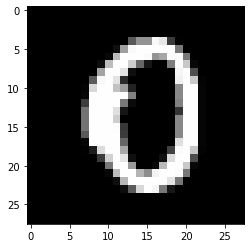

In [27]:
# Rysujemy pierwszy obrazek ze zbioru
plt.imshow(X[0].reshape(28,28), cmap='gray')

In [28]:
# Dzielimy zbiór danych, na zbiór uczący oraz zbiór testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, test_size=10000, random_state=0)

In [29]:
# Sprawdzamy jak poradzi sobie regresja logistyczna z klasyfikacją cyferek
# tricky point: nazywamy to regresją dlatego, że przewiduje prawdopodobieństwo przynależności do danej klasy
# Przy okazji sprawdzamy też ile czasu zajmuje trening
start = time.time()
clf = LogisticRegression(multi_class='multinomial', solver='saga')
clf.fit(X_train, y_train)
end = time.time()
print(f"Training time: {end-start}")

# Oceniamy skuteczność modelu na zbiorze testowym
score = clf.score(X_test, y_test)
print(f"Score: {score*100:.2f}%")

Training time: 304.9015862941742
Score: 92.54%


/home/leet/Documents/Golem/bootcamp/.venv/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


(70000, 784)
(70000, 50)
(70000, 784)


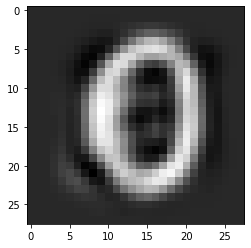

In [30]:
# Przygotowujemy transformację PCA z 50 wymiarami na wyjściu
pca = PCA(50)

# Tworzymy transformację na podstawie X i zwracamy dane w mniejszej liczbie wymiarów
projection = pca.fit_transform(X)

# Z reprezentacji w mniejszej liczbie wymiarów wracamy do oryginalnej liczby wymiarów
back_to_the_roots = pca.inverse_transform(projection)

# Sprawdzamy jak zmienił się nasz obrazek
plt.imshow(back_to_the_roots[0].reshape(28,28), cmap='gray')

# Sprawdzamy też wymiary poszczególnych tablic
print(X.shape)
print(projection.shape)
print(back_to_the_roots.shape)

In [31]:
# Dzielimy zbiór danych o mniejszej liczbie wymiarów, na zbiór uczący oraz zbiór testowy
X_proj_train, X_proj_test, y_train, y_test = train_test_split(projection, y, train_size=60000, test_size=10000, random_state=0)

In [32]:
# Następnie ponownie od zera trenujemy regresję logistyczną do klasyfikacji obrazków ...
start = time.time()
clf = LogisticRegression(multi_class='multinomial', solver='saga')
clf.fit(X_proj_train, y_train)
end = time.time()
print(f"Training time: {end-start}")

# ... i porównujemy wyniki
score = clf.score(X_proj_test, y_test)
print(f"Score: {score*100:.2f}%")

Training time: 22.241684675216675
Score: 90.79%


## Wykrywanie anomalii (Anomaly detection)

In [33]:
# Na początek wprowadźmy kilka wartości 
# Załóżmy, że chcemy mieć:
n_samples = 300  # 300 przykładów (samples) w zbiorze danych
outliers_fraction = 0.15  # 15% z tych 300 niech będzie przykładami, które odbiegają od normy
n_outliers = int(outliers_fraction * n_samples)  # a dokładniej, będzie to 45 przykładów ;)
n_inliers = n_samples - n_outliers  # w takim razie n_inliers będzie równe 255

In [34]:
# Tutaj zostaje stworzona chmura 255 punktów na płaszczyźnie z odchyleniem standardowym 0.5 od punktu (0,0)
X, _ = make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, random_state=0, n_samples=n_inliers, n_features=2)

# Ustawiamy określone ziarno losowania, żeby uzyskać powtarzalność wyników
rng = np.random.RandomState(42)

# Tutaj zostaje stworzona chmura 45 punktów na płaszczyźnie z losowymi współrzędnymi z zakresu (-10,10) na każdym wymiarze
outliers = rng.uniform(low=-10, high=10, size=(n_outliers, 2))

# Tutaj punkty "normalne" i anomalie są łączone w jedną tablice
X = np.concatenate([X, outliers], axis=0)

(300, 2)


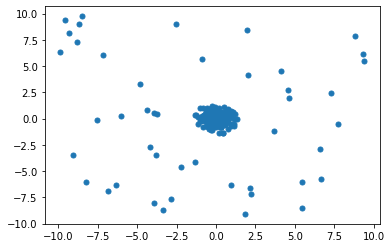

In [35]:
# Rysowanie wykresu punktów na płaszczyźnie
plt.scatter(X[:,0], X[:,1], s=25)

# Kształt tablicy współrzędnych
print(X.shape)

In [36]:
# Tworzymy obiekt służacy do wykrywania anomalii
cov = EllipticEnvelope(contamination=.1, random_state=0)

# Dopasowujemy go do dancyh
cov.fit(X)

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=0,
                 store_precision=True, support_fraction=None)

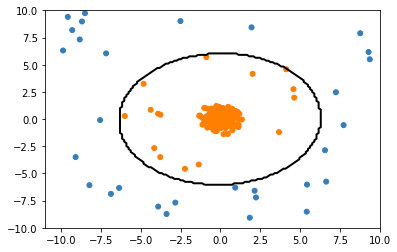

In [37]:
# Tutaj rysujemy granicę decyzyjną, wszystko co jest poza nią traktujemy jako anomalie 
xx, yy = np.meshgrid(np.linspace(-10, 10, 150), np.linspace(-10, 10, 150))
Z = cov.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black')

# Tutaj nanosimy wszystkie punkty ze zbioru i kolorujemy w zależności od tego czy są normalne czy są anomaliami
y_pred = cov.predict(X)
colors = np.array(['#377eb8', '#ff7f00'])
plt.scatter(X[:, 0], X[:, 1], s=25, color=colors[(y_pred + 1) // 2])

## Linki
https://machinelearningmastery.com/classification-versus-regression-in-machine-learning/ - klasyfikacja vs regresja  
https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51 - wykresy pudełkowe (box plots)  
https://towardsdatascience.com/linear-regression-on-boston-housing-dataset-f409b7e4a155 - regresja liniowa  
https://towardsdatascience.com/linear-regression-using-gradient-descent-97a6c8700931  - gradient schodzący (descent)  
https://www.geeksforgeeks.org/gradient-descent-in-linear-regression/  - gradient schodzący (descent) inna wersja  
https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229 - obciążenie vs wariancja  
https://dashee87.github.io/data%20science/general/Clustering-with-Scikit-with-GIFs/ - grupowanie  
http://setosa.io/ev/principal-component-analysis/ - PCA  
https://scikit-learn.org/0.20/auto_examples/plot_anomaly_comparison.html - wykrywanie anomalii  
https://scikit-learn.org/stable/modules/outlier_detection.html - więcej o wykrywaniu anomalii  